# Database query to ML input to model

### Log in to database

In [1]:
from data_extraction import DataExtractor
from data_cleaning import DataCleaning
from database_utils import DatabaseConnector
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import inspect
import yaml

#Make student conection
stud_con = DatabaseConnector()
DatabaseConnector.read_db_creds(stud_con, 'db_creds_II.yaml')
DatabaseConnector.list_db_tables(stud_con)

here is ['rnauvvis22train_II', 'rnauvvis22train_ii']


['rnauvvis22train_II', 'rnauvvis22train_ii']

In [2]:
# Inspect database tables
from sqlalchemy import inspect
inspector = inspect(stud_con.engine)
inspector.get_table_names()

['rnauvvis22train_II', 'rnauvvis22train_ii']

### Retriving and cleaning spec data from data base

In [3]:
# Select patient data table from database and clean data
#import pandas as pd
spec_dat = pd.read_sql_query("SELECT * \
        FROM \
                rnauvvis22train_II\
        ;", stud_con.engine,).set_index('index')
#cleaning data cound br done by a function in data_cleaning when required              
spec_dat.head()

,Chem,220,223,226,229,232,235,238,241,244,...,721,724,727,730,733,736,739,742,745,748
index,,,,,,,,,,,,,,,,,,,,,
0,rna,0.138,0.137,0.118,0.107,0.097,0.083,0.081,0.083,0.089,...,0.001,0.003,0.002,0.000,-0.001,0.002,0.011,0.008,0.006,0.007
1,rna,0.152,0.141,0.124,0.108,0.098,0.086,0.081,0.084,0.090,...,0.003,0.004,0.002,0.001,-0.002,0.000,0.013,0.006,0.003,0.009
2,rna,0.147,0.135,0.125,0.114,0.102,0.089,0.087,0.089,0.094,...,0.004,0.004,0.005,0.002,-0.002,0.003,0.014,0.012,0.005,0.006
3,rna,0.162,0.152,0.126,0.112,0.102,0.088,0.086,0.088,0.093,...,0.003,0.004,0.003,0.001,-0.001,0.003,0.011,0.008,0.007,0.007
4,rna,0.113,0.110,0.095,0.086,0.076,0.064,0.058,0.057,0.059,...,0.000,0.000,0.001,-0.001,-0.002,0.001,0.013,0.007,0.002,0.001


### Data cleaning

In [5]:
# should already be a df but it is not 
spec_dat = pd.DataFrame(spec_dat)

#for some reason df changes to int
print(type(spec_dat))
spec_dat.head()

<class 'pandas.core.frame.DataFrame'>


,Chem,220,223,226,229,232,235,238,241,244,...,721,724,727,730,733,736,739,742,745,748
index,,,,,,,,,,,,,,,,,,,,,
0,rna,0.138,0.137,0.118,0.107,0.097,0.083,0.081,0.083,0.089,...,0.001,0.003,0.002,0.000,-0.001,0.002,0.011,0.008,0.006,0.007
1,rna,0.152,0.141,0.124,0.108,0.098,0.086,0.081,0.084,0.090,...,0.003,0.004,0.002,0.001,-0.002,0.000,0.013,0.006,0.003,0.009
2,rna,0.147,0.135,0.125,0.114,0.102,0.089,0.087,0.089,0.094,...,0.004,0.004,0.005,0.002,-0.002,0.003,0.014,0.012,0.005,0.006
3,rna,0.162,0.152,0.126,0.112,0.102,0.088,0.086,0.088,0.093,...,0.003,0.004,0.003,0.001,-0.001,0.003,0.011,0.008,0.007,0.007
4,rna,0.113,0.110,0.095,0.086,0.076,0.064,0.058,0.057,0.059,...,0.000,0.000,0.001,-0.001,-0.002,0.001,0.013,0.007,0.002,0.001


## Building KNN clasifcation model with scikitlearn

### Splitting into scores(y) and disciptors (x)

In [6]:
# uses sklearn to normalise the spectral part of the df then do ML prep
from sklearn import preprocessing

#pandas DataFrame into a NumPy array
X = spec_dat.drop("Chem", axis=1)
X = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled)
X = X.values
y = spec_dat["Chem"]
y = y.values

### Splitting data into test and training setting

In [8]:
# Splitting Data Into Training and Test Sets for Model Evaluation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=54321
)


## Building KNN classification model with scikitlearn

### Fitting a kNN Regression 

In [9]:
# setting up model!
from sklearn.neighbors import KNeighborsClassifier
knn_c_model = KNeighborsClassifier(n_neighbors=3)

#running model
knn_c_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [10]:
# calculating rmse on training set
from sklearn.metrics import accuracy_score
from math import sqrt
train_c_preds = knn_c_model.predict(X_train)
test_c_preds = knn_c_model.predict(X_test)
train_accuracy = accuracy_score(y_train, train_c_preds)
test_accuracy = accuracy_score(y_test, test_c_preds)
print("Accuracy train:", train_accuracy)
print("Accuracy test:", test_accuracy)

Accuracy train: 0.9603960396039604
Accuracy test: 0.9230769230769231


### Using Cross Validation to Get the Best Value of k

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np
k_values = [i for i in range (2,50)]
scores = []

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

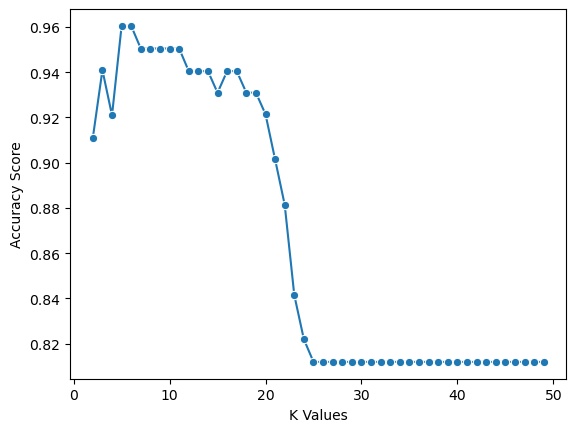

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [86]:
### train our model using the best k value

In [13]:
best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [14]:
from sklearn.metrics import precision_score, recall_score

y_pred = knn.predict(X_test)
# need to think about precision and acuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')#needs some thought
recall = recall_score(y_test, y_pred, average='macro')#needs some thought

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8846153846153846
Precision: 0.8846153846153846
Recall: 0.6666666666666666


Text(0, 0.5, 'predicted')

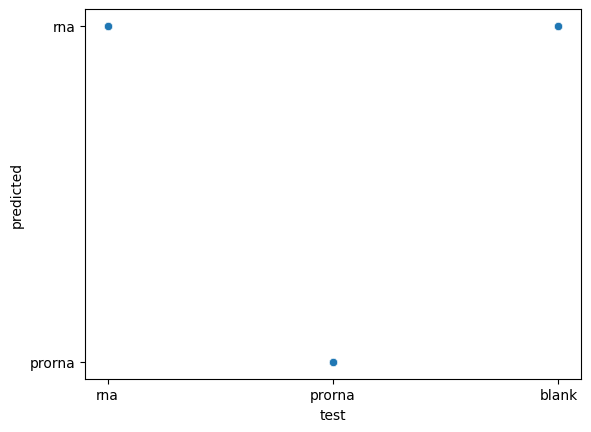

In [15]:
#does not work replace with confusion matrix
sns.scatterplot(x = y_test, y = y_pred, marker = 'o')
plt.xlabel("test")
plt.ylabel("predicted")